# Pre-trained ResNet18

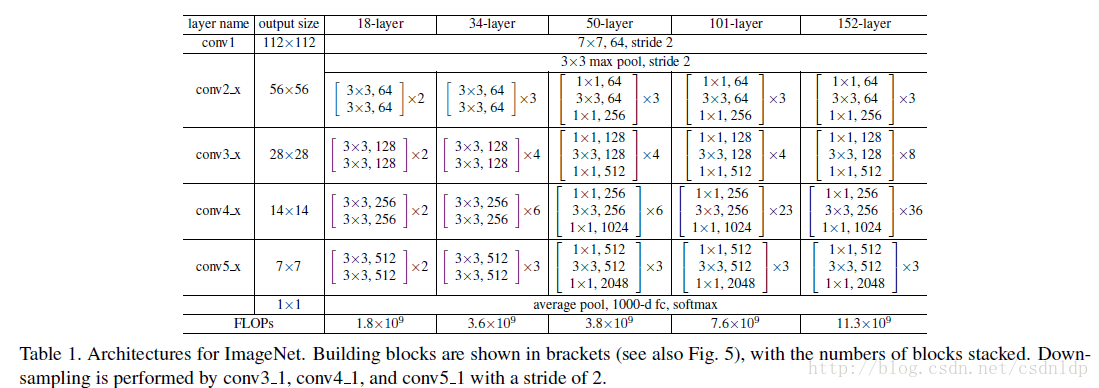

## vectorize features

In [64]:
from torchvision import models
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import pandas as pd
import os
rn18 = models.resnet18(pretrained=True)
children_counter = 0
for n,c in rn18.named_children():
    print("Children: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children:  0  Layer Name:  conv1
Children:  1  Layer Name:  bn1
Children:  2  Layer Name:  relu
Children:  3  Layer Name:  maxpool
Children:  4  Layer Name:  layer1
Children:  5  Layer Name:  layer2
Children:  6  Layer Name:  layer3
Children:  7  Layer Name:  layer4
Children:  8  Layer Name:  avgpool
Children:  9  Layer Name:  fc


In [65]:
class new_model(nn.Module):
    def __init__(self,output_layer = None):
        super().__init__()
        self.pretrained = models.resnet18(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self,x):
        x = self.net(x)
        return x

In [66]:
img = cv2.imread('../CroppedImageData/Crop_batch1_labeled/croped_IMG_1802_late_87.jpg')
def DNNfeatures(img,output_layer = 'layer2'):
    model = new_model(output_layer = output_layer)
    transf = transforms.Compose(
        [
            ## Scaling to [0.0,1.0]
            transforms.ToTensor(),
            transforms.Scale((224, 224))
        ]
    )
    img_tensor = transf(img)
    transf2 = transforms.Compose(
        [
            transforms.ToTensor(),
            
            ## Using the mean and std of Imagenet is a common practice. 
            ## If you want to train from scratch on your own dataset, you can calculate the new mean and std. 
            ## Otherwise, using the Imagenet pretrianed model with its own mean and std is recommended.
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ]
    )

    img_tensor2 = transf2(img)
    img = img_tensor2.unsqueeze(0)
    out = model(img)
    print(out.shape)

    output = F.avg_pool2d(out, kernel_size=out.shape[2], stride=out.shape[2])
    print(output.shape)
    output = output.cpu().data.numpy()
    return output.flatten()

In [67]:
DNNfeatures(img)

torch.Size([1, 128, 150, 150])
torch.Size([1, 128, 1, 1])


array([0.04419649, 0.09930734, 0.05431748, 0.0363103 , 0.03139085,
       0.02234367, 0.01123588, 0.10936815, 0.0160989 , 0.25645205,
       0.01663398, 0.03270403, 0.01472863, 0.07665905, 0.05147797,
       0.03844455, 0.02286733, 0.06884516, 0.1417031 , 0.11379038,
       0.01075502, 0.03901786, 0.05479496, 0.03010337, 0.07218718,
       0.11172603, 0.03358997, 0.06522342, 0.08125043, 0.14209527,
       0.02792805, 0.11704616, 0.10193905, 0.04194355, 0.02811783,
       0.00875607, 0.27948526, 0.0751413 , 0.12250692, 0.23697741,
       0.12752897, 0.23595569, 0.06724163, 0.26450226, 0.07213363,
       0.10484922, 0.08460989, 0.03961629, 0.09477466, 0.04977171,
       0.03409054, 0.02009875, 0.04371288, 0.04989915, 0.18298364,
       0.06095923, 0.01757729, 0.05325939, 0.33298844, 0.09011552,
       0.06458691, 0.04354975, 0.02510119, 0.13274606, 0.02729868,
       0.02667243, 0.23788053, 0.21134898, 0.02259927, 0.02950503,
       0.05209127, 0.02582915, 0.03508218, 0.01142867, 0.26754

In [72]:
def batchExtractDNN(inputDir,outputDir):
    imread_failed = []
    features = []
    index = []
    df = pd.DataFrame(columns = range(1,129))
    if os.path.isdir(outputDir):
        pass
    else:
        os.mkdir(outputDir)
    for (path,dirname,filenames) in os.walk(inputDir):
        for image in filenames:
            try:
                src = path + image
                imgName = image.split('.')[0]
                img = cv2.imread(src)
                feature = DNNfeatures(img) 
                features.append(feature)
                index.append(imgName)
                df = pd.DataFrame(features,columns = range(1,129),index = index)
                df.index.name = 'Image'
                df.to_csv(outputDir+'DNNFeaturesLayer2.csv')
            except:
                imread_failed.append(image)
    display(df)
    return df

In [73]:
df = batchExtractDNN('../testTrainingDataMix/','../csvFiles/')
df

/Users/huiminhan/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 113, 113])
torch.Size([1, 128, 1, 1])
torch.Size([1,

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,128
Image,,,,,,,,,,,,,,,,,,,,,
1802late79,0.068275,0.157592,0.082554,0.064972,0.120839,0.090099,0.026834,0.171146,0.034943,0.295401,...,0.053138,0.180098,0.093527,0.189275,0.105053,0.173725,0.043706,0.054691,0.308349,0.070121
1802late92,0.049229,0.156108,0.081191,0.055901,0.119174,0.091269,0.021899,0.161272,0.026484,0.294709,...,0.047123,0.170871,0.095923,0.187704,0.101171,0.174721,0.034620,0.047797,0.303087,0.067094
1802late86,0.048557,0.160526,0.085549,0.061356,0.122491,0.088698,0.026238,0.155925,0.029371,0.294300,...,0.050919,0.181880,0.092090,0.188571,0.108156,0.173544,0.038042,0.048806,0.307608,0.072931
1802late87,0.055396,0.158305,0.085610,0.059512,0.131009,0.095288,0.025966,0.154091,0.034035,0.299607,...,0.054305,0.182068,0.101867,0.188572,0.110286,0.174302,0.039759,0.051314,0.311195,0.074897
1802late93,0.061678,0.156793,0.084858,0.061389,0.126731,0.091486,0.025799,0.169657,0.031777,0.301117,...,0.054623,0.178723,0.099569,0.189647,0.107624,0.173605,0.041325,0.050713,0.314434,0.068230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804lateDisease1,0.072365,0.156816,0.081346,0.062466,0.144034,0.110753,0.022357,0.173974,0.039538,0.298837,...,0.070894,0.198652,0.125392,0.190552,0.127110,0.182539,0.053112,0.053712,0.323887,0.067490
1808readyDisease6,0.077592,0.160438,0.080895,0.054826,0.148834,0.103382,0.026975,0.186661,0.045962,0.296928,...,0.065092,0.181659,0.128114,0.189473,0.121904,0.178137,0.053303,0.053871,0.320057,0.073853
1802late98,0.041302,0.155528,0.080929,0.061675,0.117547,0.080901,0.019344,0.151659,0.029598,0.291539,...,0.045110,0.177037,0.092639,0.186551,0.107482,0.164361,0.034237,0.041827,0.296227,0.067841


,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,128
Image,,,,,,,,,,,,,,,,,,,,,
1802late79,0.068275,0.157592,0.082554,0.064972,0.120839,0.090099,0.026834,0.171146,0.034943,0.295401,...,0.053138,0.180098,0.093527,0.189275,0.105053,0.173725,0.043706,0.054691,0.308349,0.070121
1802late92,0.049229,0.156108,0.081191,0.055901,0.119174,0.091269,0.021899,0.161272,0.026484,0.294709,...,0.047123,0.170871,0.095923,0.187704,0.101171,0.174721,0.034620,0.047797,0.303087,0.067094
1802late86,0.048557,0.160526,0.085549,0.061356,0.122491,0.088698,0.026238,0.155925,0.029371,0.294300,...,0.050919,0.181880,0.092090,0.188571,0.108156,0.173544,0.038042,0.048806,0.307608,0.072931
1802late87,0.055396,0.158305,0.085610,0.059512,0.131009,0.095288,0.025966,0.154091,0.034035,0.299607,...,0.054305,0.182068,0.101867,0.188572,0.110286,0.174302,0.039759,0.051314,0.311195,0.074897
1802late93,0.061678,0.156793,0.084858,0.061389,0.126731,0.091486,0.025799,0.169657,0.031777,0.301117,...,0.054623,0.178723,0.099569,0.189647,0.107624,0.173605,0.041325,0.050713,0.314434,0.068230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804lateDisease1,0.072365,0.156816,0.081346,0.062466,0.144034,0.110753,0.022357,0.173974,0.039538,0.298837,...,0.070894,0.198652,0.125392,0.190552,0.127110,0.182539,0.053112,0.053712,0.323887,0.067490
1808readyDisease6,0.077592,0.160438,0.080895,0.054826,0.148834,0.103382,0.026975,0.186661,0.045962,0.296928,...,0.065092,0.181659,0.128114,0.189473,0.121904,0.178137,0.053303,0.053871,0.320057,0.073853
1802late98,0.041302,0.155528,0.080929,0.061675,0.117547,0.080901,0.019344,0.151659,0.029598,0.291539,...,0.045110,0.177037,0.092639,0.186551,0.107482,0.164361,0.034237,0.041827,0.296227,0.067841


In [54]:
# df_late = df[df.index.str.contains(pat = '1802')]
df_lateDisease = df[df.index.str.contains(pat = 'lateDisease')]
df_readyDisease = df[df.index.str.contains(pat = 'readyDisease')]

Image
1808readyDisease8    0.712930
1808readyDisease9    0.778686
1808readyDisease2    0.771159
1808readyDisease3    0.742301
1808readyDisease1    0.761857
1808readyDisease4    0.817316
1808readyDisease5    0.702035
1808readyDisease7    0.788563
1808readyDisease6    0.703912
Name: 336, dtype: float64

<AxesSubplot:>

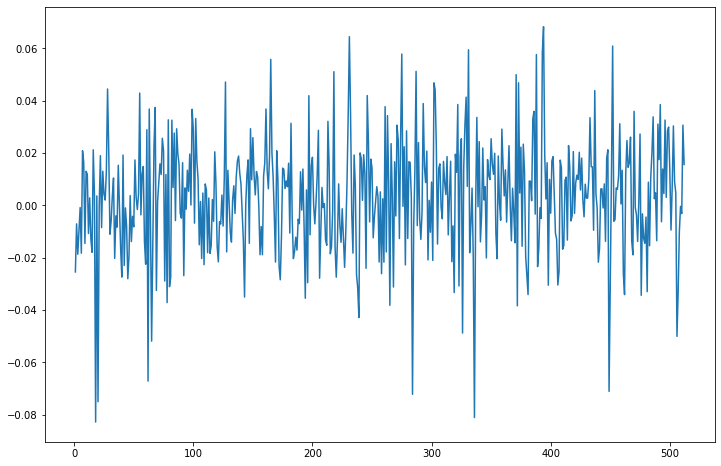

In [59]:
a = df_readyDisease.mean()-df_lateDisease.mean()
a.plot(figsize = (12,8))

In [60]:
a[abs(a)>0.06]

18    -0.082748
20    -0.074988
62    -0.067113
231    0.064441
284   -0.072149
336   -0.081035
394    0.068261
449   -0.071041
452    0.060881
dtype: float64

## Interprete Layers

In [1]:
! pwd

/Users/huiminhan/Desktop/InfoVis/CropAI/FeaturesExtraction


In [75]:
from PIL import Image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

def save_img(tensor, name):
    tensor = tensor.permute((1, 0, 2, 3))
    im = make_grid(tensor, normalize=True, scale_each=True, nrow=16, padding=2).permute((1, 2, 0))
    im = (im.data.numpy() * 255.).astype(np.uint8)
    Image.fromarray(im).save(name + '.jpg')

# img = Image.open('../testTrainingDataMix/1803lateDisease5.jpg')
img = Image.open('../testTrainingDataMix/1793ready73.jpg')
model = models.resnet18(pretrained=True)

transform = transforms.Compose([
            transforms.Scale((224, 224)),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])

img = transform(img)
img = img.unsqueeze(0)
      
new_model = nn.Sequential(*list(model.children())[:5])
f3 = new_model(img)
save_img(f3, '../DNNlayers/r_layer1')

new_model = nn.Sequential(*list(model.children())[:6])
f4 = new_model(img) 
save_img(f4, '../DNNlayers/r_layer2')

new_model = nn.Sequential(*list(model.children())[:7])
print(new_model)
f5 = new_model(img)  
print(f5.shape)
save_img(f5, '../DNNlayers/r_layer3')

new_model = nn.Sequential(*list(model.children())[:8])
print(new_model)
f6 = new_model(img) 
print(f6.shape)
save_img(f6, '../DNNlayers/r_layer4')


/Users/huiminhan/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

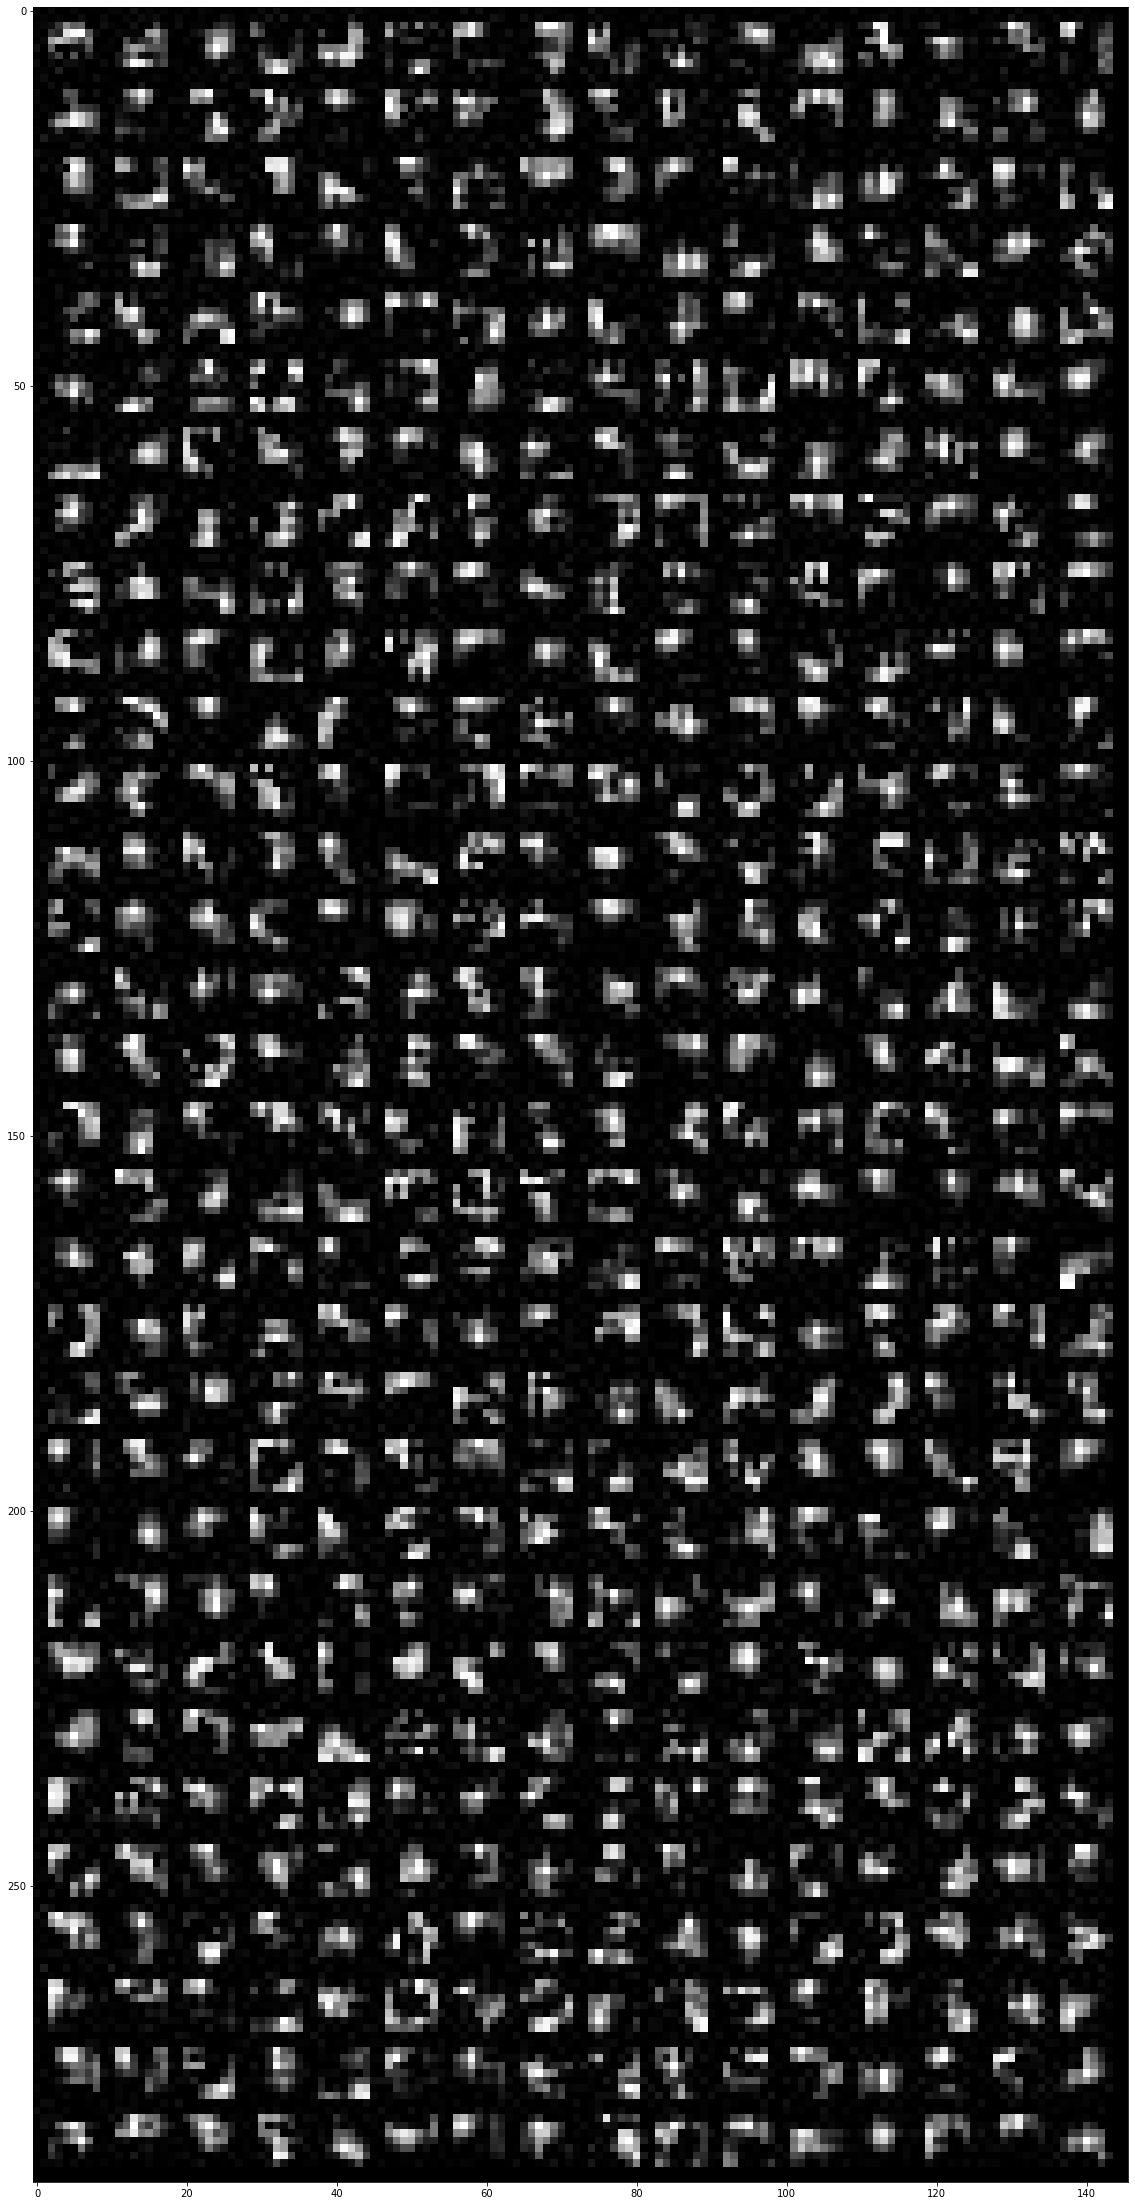

In [62]:
from IPython.core.pylabtools import figsize
figsize(20, 40)
rd_layer4 = cv2.imread('../DNNlayers/rd_layer4.jpg')
# rd_layer4
plt.imshow(rd_layer4)

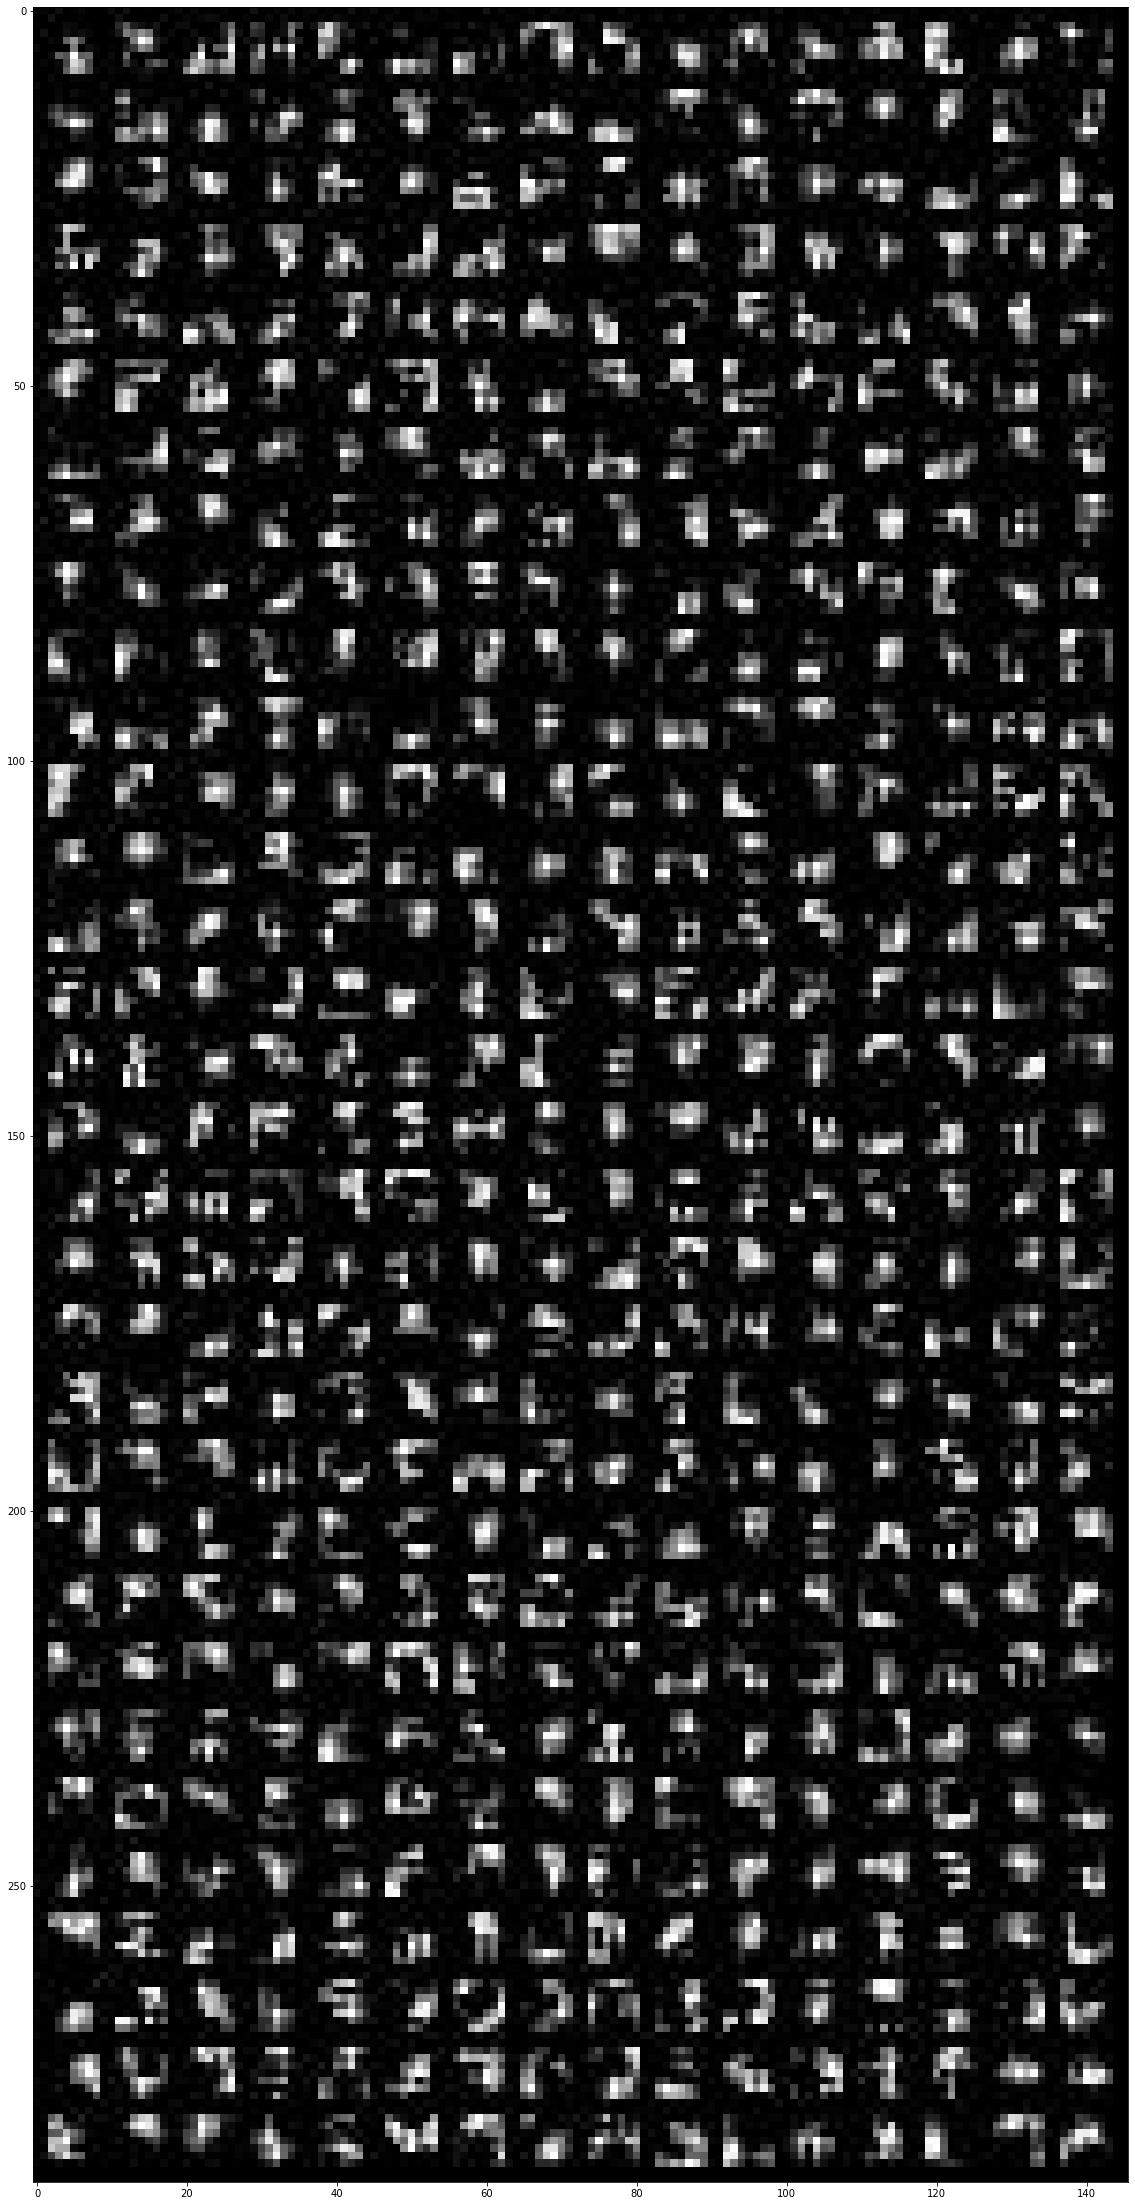

In [36]:
ld_layer4 = cv2.imread('../DNNlayers/ld_layer4.jpg')
# rd_layer4
plt.imshow(ld_layer4)